## Introduction
From Kaggle open resource, we had **training** dataset, **public test** dataset (which is then used as validation dataset for our project), and further a **private test** dataset (same size with public test dataset and will be used as data for evaluating the prediction performance).

Image set of 35,887 examples, with training-set : **80%** validation-set : **10%** test-set : **10%**.

## Objectives
(i) To apply Convolutional neural networks (CNN) for facial expression recognition.

(ii) To correctly classify each facial image into one of the seven facial emotion categories: **anger**, **disgust**, **fear**, **happiness**, **sadness**, **surprise**, and **neutral**.


---------------------------------------------------------------------------------------
## Import libraries

In [2]:
import tensorflow as tf

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os

## FER Dataset Overview

In [4]:
import os
import json
import zipfile

# Step 1: Install Kaggle API client (if not already installed)
# This line is commented out as Colab often has it pre-installed.
# Uncomment and run if you encounter 'kaggle: command not found' errors.
# !pip install kaggle --quiet

# Step 2: Create the .kaggle directory
kaggle_dir = os.path.join(os.path.expanduser('~'), '.kaggle')
os.makedirs(kaggle_dir, exist_ok=True)

# Step 3: Write your Kaggle API credentials to kaggle.json
kaggle_json_path = os.path.join(kaggle_dir, 'kaggle.json')
kaggle_credentials = {
    "username": "shashikantbind123",
    "key": "e6b4e9e648a93890b109b89cba96df99"
}

with open(kaggle_json_path, 'w') as f:
    json.dump(kaggle_credentials, f)

# Step 4: Set appropriate permissions for kaggle.json
os.chmod(kaggle_json_path, 0o600)
print("Kaggle API credentials configured.")

# --- Download and Unzip deadskull7/fer2013 ---
dataset_slug_fer2013 = "deadskull7/fer2013"
download_target_dir_fer2013 = "fer2013_new_data" # Create a specific folder for downloaded content

# Ensure the download_target_dir_fer2013 exists
os.makedirs(download_target_dir_fer2013, exist_ok=True)

print(f"Attempting to download Kaggle dataset: {dataset_slug_fer2013} to '{download_target_dir_fer2013}'...")
!kaggle datasets download -d {dataset_slug_fer2013} -p {download_target_dir_fer2013}

zip_file_name_fer2013 = os.path.join(download_target_dir_fer2013, f"{dataset_slug_fer2013.split('/')[-1]}.zip")

if os.path.exists(zip_file_name_fer2013):
    print(f"Unzipping {zip_file_name_fer2013}...")
    with zipfile.ZipFile(zip_file_name_fer2013, 'r') as zip_ref:
        zip_ref.extractall(download_target_dir_fer2013) # Extract into the target directory
    print(f"Dataset {dataset_slug_fer2013} downloaded and unzipped successfully.")
    os.remove(zip_file_name_fer2013)
    print(f"Cleaned up {zip_file_name_fer2013}.")
else:
    print(f"Error: Downloaded zip file '{zip_file_name_fer2013}' not found. Please check dataset slug or Kaggle API configuration.")

# --- Download and Unzip shawon10/ckplus ---
dataset_slug_ckplus = "shawon10/ckplus"
download_target_dir_ckplus = "ckplus_data" # Create a specific folder for downloaded content

# Ensure the download_target_dir_ckplus exists
os.makedirs(download_target_dir_ckplus, exist_ok=True)

print(f"\nAttempting to download Kaggle dataset: {dataset_slug_ckplus} to '{download_target_dir_ckplus}'...")
!kaggle datasets download -d {dataset_slug_ckplus} -p {download_target_dir_ckplus}

zip_file_name_ckplus = os.path.join(download_target_dir_ckplus, f"{dataset_slug_ckplus.split('/')[-1]}.zip")

if os.path.exists(zip_file_name_ckplus):
    print(f"Unzipping {zip_file_name_ckplus}...")
    with zipfile.ZipFile(zip_file_name_ckplus, 'r') as zip_ref:
        zip_ref.extractall(download_target_dir_ckplus) # Extract into the target directory
    print(f"Dataset {dataset_slug_ckplus} downloaded and unzipped successfully.")
    os.remove(zip_file_name_ckplus)
    print(f"Cleaned up {zip_file_name_ckplus}.")
else:
    print(f"Error: Downloaded zip file '{zip_file_name_ckplus}' not found. Please check dataset slug or Kaggle API configuration.")

print("\n--- Download process complete ---")
print(f"FER2013 dataset is located in the '{download_target_dir_fer2013}' directory.")
print(f"CKPLUS dataset is located in the '{download_target_dir_ckplus}' directory.")


Kaggle API credentials configured.
Attempting to download Kaggle dataset: deadskull7/fer2013 to 'fer2013_new_data'...
Dataset URL: https://www.kaggle.com/datasets/deadskull7/fer2013
License(s): CC0-1.0
  0% 0.00/96.6M [00:00<?, ?B/s]
100% 96.6M/96.6M [00:00<00:00, 1.68GB/s]
Unzipping fer2013_new_data/fer2013.zip...
Dataset deadskull7/fer2013 downloaded and unzipped successfully.
Cleaned up fer2013_new_data/fer2013.zip.

Attempting to download Kaggle dataset: shawon10/ckplus to 'ckplus_data'...
Dataset URL: https://www.kaggle.com/datasets/shawon10/ckplus
License(s): CC0-1.0
  0% 0.00/3.63M [00:00<?, ?B/s]
100% 3.63M/3.63M [00:00<00:00, 735MB/s]
Unzipping ckplus_data/ckplus.zip...
Dataset shawon10/ckplus downloaded and unzipped successfully.
Cleaned up ckplus_data/ckplus.zip.

--- Download process complete ---
FER2013 dataset is located in the 'fer2013_new_data' directory.
CKPLUS dataset is located in the 'ckplus_data' directory.


In [5]:
data = pd.read_csv('/content/fer2013_new_data/fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [6]:
#preview first 5 row of data
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
#check usage values
#80% training, 10% validation and 10% test
data.Usage.value_counts()

,count
Usage,
Training,28709
PublicTest,3589
PrivateTest,3589


In [8]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


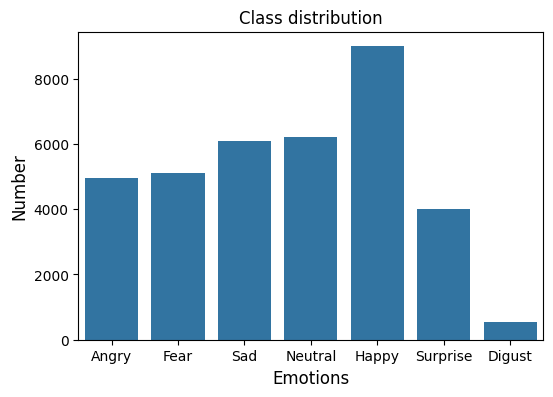

In [9]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(x=emotion_counts.emotion, y=emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

#### Let's look at some images...

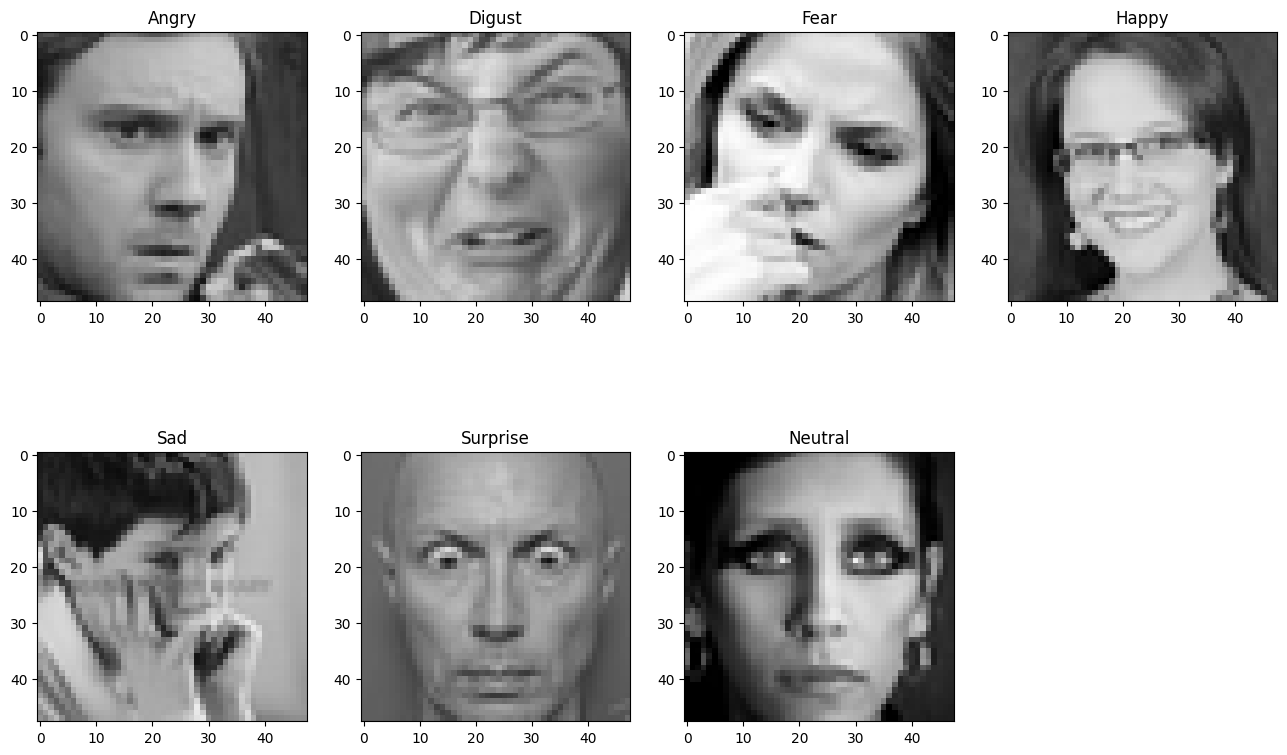

In [10]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return (image.astype(np.uint8), emotion)

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()

----------------------------------------------------------------------------------
## Pre-processing data
#### Summary:
1. Splitting dataset into 3 parts: train, validation, test
1. Convert strings to lists of integers
1. Reshape to 48x48 and normalise grayscale image with 255.0
1. Perform one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

In [11]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
#data_train = data_train[data_train['emotion']!=1]
#data_val = data_val[data_val['emotion']!=1]
##data_test = data_test[data_test['emotion']!=1]
#data_train['emotion'] = data_train['emotion'].apply(lambda ele: ele-1 if ele > 0 else ele)
#data_test['emotion'] = data_test['emotion'].apply(lambda ele: ele-1 if ele > 0 else ele)
#data_val['emotion'] = data_val['emotion'].apply(lambda ele: ele-1 if ele > 0 else ele)
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


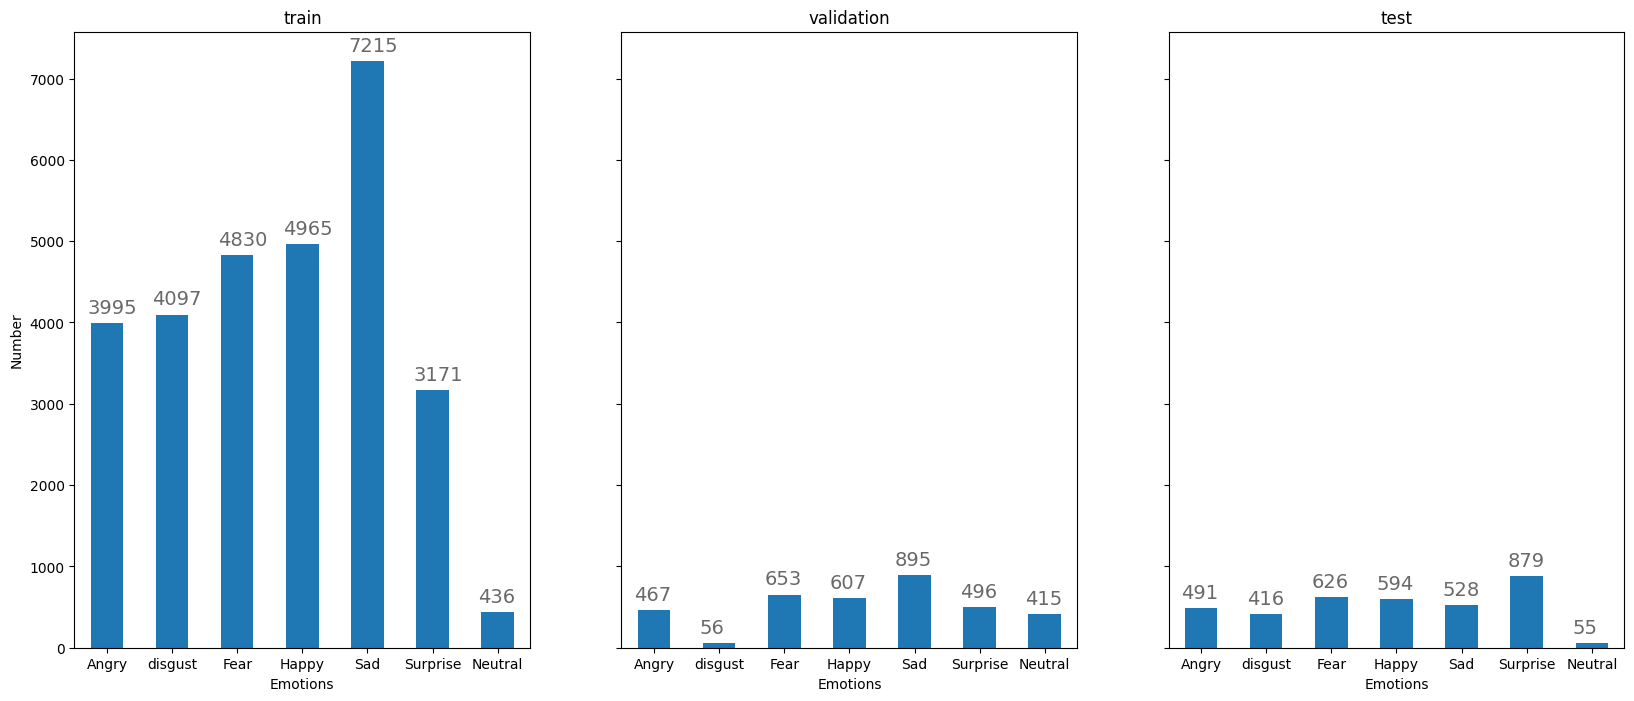

In [12]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry','disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)

    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)


fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

Notice that the later two subplots share the same y-axis with the first subplot.

The size of **train**, **validation**, **test** are **80%**, **10%** and **10%**, respectively.

The exact number of each class of these datasets are written on top of their x-axis bar.

In [13]:
#initilize parameters
num_classes = 7
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [14]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0
    data_Y = to_categorical(df['emotion'], num_classes)
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y


train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


# **CK+ OVERVIEW**

In [15]:
import os
import cv2

data_path = '/content/ckplus_data/CK+48'
data_dir_list = os.listdir(data_path)

img_data_list=[]

numbers = []
c=0

for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(48,48))
        input_img_resize = np.reshape(input_img_resize,(48,48,1))
        img_data_list.append(input_img_resize)
        c += 1
    numbers.append(c)
    c = 0

img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loaded the images of dataset-sadness

Loaded the images of dataset-disgust

Loaded the images of dataset-fear

Loaded the images of dataset-contempt

Loaded the images of dataset-surprise

Loaded the images of dataset-happy

Loaded the images of dataset-anger



(981, 48, 48, 1)

In [16]:
pl = img_data
np.reshape(pl[0],(48,48,1))
pl[0].shape

(48, 48, 1)

In [17]:


num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:134]=0 #135
labels[135:188]=6 #54
labels[189:365]=1 #177
labels[366:440]=2 #75
labels[441:647]=3 #207
labels[648:731]=4 #84
labels[732:980]=5 #249

names = ['Angry','disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def getLabel(id):
    return ['Angry','disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'][id]

In [18]:
from keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Y = to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=2)

In [19]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net():

    inputs = Input(shape=(48, 48, 1))
    num_filters = 32

    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)

    num_blocks_list = [2,3, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2

    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    #outputs = Dense(10, activation='softmax')(t)

    model = Model(inputs, t)

    return model

#output layer
#model.add(Dense(6,activation='softmax'))

In [20]:
pip install stn

In [21]:
from tensorflow import keras
from keras import layers
from stn import spatial_transformer_network as transformer
import tensorflow as tf # Import TensorFlow for custom layer

# Define a custom Keras Layer to wrap the spatial_transformer_network
class SpatialTransformerLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(SpatialTransformerLayer, self).__init__(**kwargs)

    def call(self, inputs):
        input_fmap, theta = inputs
        return transformer(input_fmap, theta)

img_inputs = keras.Input(shape=(48,48,1))

locnet = layers.Conv2D(32,3, padding='same')(img_inputs)
locnet = layers.MaxPooling2D(3, padding='same')(locnet)
locnet = layers.Activation('relu')(locnet)
locnet = layers.BatchNormalization()(locnet)
locnet = layers.Conv2D(64,3, padding='same')(locnet)
locnet = layers.MaxPooling2D(3, padding='same')(locnet)
locnet = layers.Activation('relu')(locnet)
locnet = layers.BatchNormalization()(locnet)
locnet = layers.Conv2D(96,3, padding='same')(locnet)
feat_map = layers.Activation('relu')(locnet)
locnet = layers.BatchNormalization()(locnet)
locnet = layers.Flatten()(feat_map)
locnet = layers.Dense(90, activation='relu',kernel_regularizer='l2')(locnet)
locnet = layers.Dropout(0.2)(locnet)
locnet = layers.Dense(32, activation='relu', kernel_regularizer='l2')(locnet)
theta = layers.Dense(6, activation='linear')(locnet)

locnet = keras.Model(img_inputs, theta, name="locnet")
#locnet.summary()

#spatial transformer network
# Use the custom SpatialTransformerLayer to wrap the transformer function
outstn = SpatialTransformerLayer()([feat_map, theta])



#feature extraction network
fe = layers.Conv2D(32,3, padding='same')(img_inputs)
fe = layers.BatchNormalization()(fe)
fe = layers.Activation('relu')(fe)
fe = layers.MaxPooling2D(3,padding='same')(fe)
fe = layers.Conv2D(64,3, padding='same')(fe)
fe = layers.BatchNormalization()(fe)
fe = layers.Activation('relu')(fe)
fe = layers.MaxPooling2D(3,padding='same')(fe)
fe = layers.Conv2D(96,3, padding='same')(fe)
fe = layers.Activation('relu')(fe)
do = layers.BatchNormalization()(fe)

fe = keras.Model(img_inputs, do, name="feature extractor")
#fe.summary()

add = layers.Add()([outstn, do])

flats = layers.Flatten()(add)
flats = layers.Dense(64, activation='relu',  kernel_regularizer='l2')(flats)
flats = layers.Dropout(0.4)(flats)
flats = layers.Dense(32, activation='relu',  kernel_regularizer='l2')(flats)
flats = layers.Dropout(0.4)(flats)
#output = layers.Dense(6, activation='softmax')(flats)

x1 = layers.Dense(7, activation='linear')(flats)
x2 = layers.Dense(7,activation='linear')(flats)
x3 = layers.Dense(7,activation='linear')(flats)
x4 = layers.Dense(7,activation='linear')(flats)
avg = layers.Average()([x1, x2, x3, x4])
out = layers.Dense(7, activation='softmax')(avg)

model = keras.Model(inputs=img_inputs, outputs=out, name="FEMSTN")

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    0.1,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=lr_schedule),
              metrics=['accuracy'])

model.summary()

Model: "FEMSTN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 48, 48,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 16, 16,    │          0 │ max_pooling2d[0]… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        128 │ activation[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 6, 6, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 48, 48,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 6, 6, 64)  │          0 │ max_pooling2d_1[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 64)  │        256 │ activation_1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 6, 6, 96)  │     55,392 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 6, 6, 96)  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3456)      │          0 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 688,116 (2.62 MB)

 Trainable params: 687,540 (2.62 MB)

 Non-trainable params: 576 (2.25 KB)

In [22]:
from keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

In [23]:
from keras.layers import LeakyReLU

model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(48, 48, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


#module 2
model.add(Conv2D(4*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(4*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


#module 3
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))


#dense 4
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(7, activation='softmax'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    0.01,
    decay_steps=100,
    decay_rate=0.5,
    staircase=False)

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(0.01),
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 256)    │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 46, 46, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 46, 46, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 46, 46, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 46, 46, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 46, 46, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 23, 23, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 23, 23, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 23, 23, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 23, 23, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 23, 23, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 23, 23, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 23, 23, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 11, 11, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 11, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 11, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3200)           │             

 Total params: 3,075,335 (11.73 MB)

 Trainable params: 3,072,007 (11.72 MB)

 Non-trainable params: 3,328 (13.00 KB)

In [24]:
batch_size = 128
epochs = 100

from keras.layers import Average, Add
from keras.models import Model

model = create_res_net()

x1 = Dense(6)(model.output)
x2 = Dense(6)(model.output)
x3 = Dense(6)(model.output)
x4 = Dense(6)(model.output)
avg = Average()([x1, x2, x3, x4])
out = Dense(6, activation='softmax')(avg)
model = Model(inputs=model.input, outputs=out)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.1,
    decay_steps=1000,
    decay_rate=0.46,
    staircase=True)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
              metrics=['accuracy'])

model.summary()

In [42]:
import tensorflow as tf

# Check for GPU availability
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    print(f"Found GPU device(s): {gpu_devices}")
    # Set TensorFlow to use a specific GPU or allow growth
    try:
        # Allow memory growth to prevent pre-allocating all GPU memory
        for gpu in gpu_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpu_devices)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
    print("GPU will be used for training.")
else:
    print("No GPU devices found. Training will proceed on CPU.")

Found GPU device(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs
GPU will be used for training.


In [26]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True
)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

cp_path = './model_bacc.h5'
cpl_path = './model_fer_bloss.h5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=cp_path,save_best_only=True, save_weights_only=False, verbose=0, monitor='val_accuracy')
cpl = tf.keras.callbacks.ModelCheckpoint(filepath=cpl_path,save_best_only=True, save_weights_only=False, verbose=2, monitor='val_loss')
history = model.fit(data_generator.flow(train_X, train_Y, 256),
                                epochs=100,
                                verbose=1,
                                callbacks = [cp, cpl, es],
                                validation_data=(val_X, val_Y))

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.2427 - loss: 1.8982


Epoch 1: val_loss improved from inf to 2.08553, saving model to ./model_fer_bloss.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 126s 663ms/step - accuracy: 0.2429 - loss: 1.8974 - val_accuracy: 0.1808 - val_loss: 2.0855
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.3483 - loss: 1.6350


Epoch 2: val_loss improved from 2.08553 to 1.64815, saving model to ./model_fer_bloss.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 509ms/step - accuracy: 0.3485 - loss: 1.6346 - val_accuracy: 0.3500 - val_loss: 1.6482
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.4362 - loss: 1.4578


Epoch 3: val_loss improved from 1.64815 to 1.60197, saving model to ./model_fer_bloss.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 509ms/step - accuracy: 0.4363 - loss: 1.4574 - val_accuracy: 0.3823 - val_loss: 1.6020
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.4820 - loss: 1.3437


Epoch 4: val_loss improved from 1.60197 to 1.41658, saving model to ./model_fer_bloss.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 511ms/step - accuracy: 0.4822 - loss: 1.3433 - val_accuracy: 0.4500 - val_loss: 1.4166
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.5413 - loss: 1.2088


Epoch 5: val_loss improved from 1.41658 to 1.40658, saving model to ./model_fer_bloss.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 511ms/step - accuracy: 0.5413 - loss: 1.2088 - val_accuracy: 0.4912 - val_loss: 1.4066
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.5537 - loss: 1.1705


Epoch 6: val_loss improved from 1.40658 to 1.25624, saving model to ./model_fer_bloss.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 512ms/step - accuracy: 0.5538 - loss: 1.1704 - val_accuracy: 0.5222 - val_loss: 1.2562
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.5762 - loss: 1.1226


Epoch 7: val_loss improved from 1.25624 to 1.14503, saving model to ./model_fer_bloss.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 511ms/step - accuracy: 0.5762 - loss: 1.1225 - val_accuracy: 0.5678 - val_loss: 1.1450
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.5934 - loss: 1.0731
Epoch 8: val_loss did not improve from 1.14503
113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 509ms/step - accuracy: 0.5933 - loss: 1.0732 - val_accuracy: 0.5375 - val_loss: 1.2388
Epoch 9/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.5973 - loss: 1.0613
Epoch 9: val_loss did not improve from 1.14503
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 508ms/step - accuracy: 0.5973 - loss: 1.0613 - val_accuracy: 0.5422 - val_loss: 1.2834
Epoch 10/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.6112 - loss: 1.0332


Epoch 10: val_loss improved from 1.14503 to 1.10072, saving model to ./model_fer_bloss.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 510ms/step - accuracy: 0.6112 - loss: 1.0332 - val_accuracy: 0.5890 - val_loss: 1.1007
Epoch 11/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.6130 - loss: 1.0148


Epoch 11: val_loss did not improve from 1.10072
113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 510ms/step - accuracy: 0.6130 - loss: 1.0148 - val_accuracy: 0.5932 - val_loss: 1.1017
Epoch 12/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.6297 - loss: 0.9838
Epoch 12: val_loss improved from 1.10072 to 1.10071, saving model to ./model_fer_bloss.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 509ms/step - accuracy: 0.6297 - loss: 0.9838 - val_accuracy: 0.5893 - val_loss: 1.1007
Epoch 13/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.6333 - loss: 0.9733


Epoch 13: val_loss improved from 1.10071 to 1.05836, saving model to ./model_fer_bloss.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 511ms/step - accuracy: 0.6333 - loss: 0.9734 - val_accuracy: 0.6105 - val_loss: 1.0584
Epoch 14/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.6441 - loss: 0.9525


Epoch 14: val_loss improved from 1.05836 to 1.04823, saving model to ./model_fer_bloss.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 510ms/step - accuracy: 0.6441 - loss: 0.9526 - val_accuracy: 0.6141 - val_loss: 1.0482
Epoch 15/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.6521 - loss: 0.9318
Epoch 15: val_loss did not improve from 1.04823
113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 509ms/step - accuracy: 0.6520 - loss: 0.9319 - val_accuracy: 0.5999 - val_loss: 1.0926
Epoch 16/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.6503 - loss: 0.9248
Epoch 16: val_loss improved from 1.04823 to 1.04318, saving model to ./model_fer_bloss.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 509ms/step - accuracy: 0.6504 - loss: 0.9248 - val_accuracy: 0.6108 - val_loss: 1.0432
Epoch 17/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.6611 - loss: 0.9046
Epoch 17: val_loss did not improve from 1.04318
113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 508ms/step - accuracy: 0.6610 - loss: 0.9047 - val_accuracy: 0.6010 - val_loss: 1.0789
Epoch 18/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.6606 - loss: 0.9106
Epoch 18: val_loss did not improve from 1.04318
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 507ms/step - accuracy: 0.6606 - loss: 0.9105 - val_accuracy: 0.6007 - val_loss: 1.0788
Epoch 19/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.6609 - loss: 0.9014
Epoch 19: val_loss did not improve from 1.04318
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 507ms/step - accuracy: 0.6609 - loss: 0.9014 - val_accuracy: 0.6088 - val_loss: 1.0585
Epoch 20/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.6740 - loss: 0.8742


Epoch 20: val_loss did not improve from 1.04318
113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 510ms/step - accuracy: 0.6740 - loss: 0.8742 - val_accuracy: 0.6252 - val_loss: 1.0802
Epoch 21/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.6828 - loss: 0.8530
Epoch 21: val_loss did not improve from 1.04318
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 507ms/step - accuracy: 0.6828 - loss: 0.8531 - val_accuracy: 0.6160 - val_loss: 1.0521
Epoch 22/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.6792 - loss: 0.8550
Epoch 22: val_loss did not improve from 1.04318
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 508ms/step - accuracy: 0.6792 - loss: 0.8550 - val_accuracy: 0.5910 - val_loss: 1.1125
Epoch 23/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.6868 - loss: 0.8327
Epoch 23: val_loss did not improve from 1.04318
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 507ms/step - accuracy: 0.6868 - loss: 0.8328 - val_accuracy: 0.5887 - val_loss: 1.2222
Epoch 24/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step -


Epoch 25: val_loss improved from 1.04318 to 1.03935, saving model to ./model_fer_bloss.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 510ms/step - accuracy: 0.6942 - loss: 0.8255 - val_accuracy: 0.6328 - val_loss: 1.0394
Epoch 26/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.6967 - loss: 0.8057
Epoch 26: val_loss did not improve from 1.03935
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 507ms/step - accuracy: 0.6967 - loss: 0.8058 - val_accuracy: 0.5935 - val_loss: 1.1456
Epoch 27/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.7025 - loss: 0.7953
Epoch 27: val_loss did not improve from 1.03935
113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 509ms/step - accuracy: 0.7025 - loss: 0.7954 - val_accuracy: 0.6096 - val_loss: 1.0597
Epoch 28/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.7021 - loss: 0.7921


Epoch 28: val_loss improved from 1.03935 to 0.98869, saving model to ./model_fer_bloss.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 510ms/step - accuracy: 0.7021 - loss: 0.7922 - val_accuracy: 0.6509 - val_loss: 0.9887
Epoch 29/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.7118 - loss: 0.7795
Epoch 29: val_loss did not improve from 0.98869
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 507ms/step - accuracy: 0.7117 - loss: 0.7796 - val_accuracy: 0.6280 - val_loss: 1.0989
Epoch 30/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.7150 - loss: 0.7676
Epoch 30: val_loss did not improve from 0.98869
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 508ms/step - accuracy: 0.7150 - loss: 0.7677 - val_accuracy: 0.5882 - val_loss: 1.1543
Epoch 31/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.7178 - loss: 0.7648
Epoch 31: val_loss did not improve from 0.98869
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 508ms/step - accuracy: 0.7177 - loss: 0.7649 - val_accuracy: 0.6227 - val_loss: 1.1364
Epoch 32/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.7277 - loss: 0.7382
Epoch 32: val_lo


Epoch 35: val_loss did not improve from 0.98869
113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 508ms/step - accuracy: 0.7241 - loss: 0.7310 - val_accuracy: 0.6553 - val_loss: 0.9930
Epoch 36/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.7331 - loss: 0.7152
Epoch 36: val_loss did not improve from 0.98869
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 508ms/step - accuracy: 0.7330 - loss: 0.7153 - val_accuracy: 0.6389 - val_loss: 1.0661
Epoch 37/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.7289 - loss: 0.7232
Epoch 37: val_loss did not improve from 0.98869
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 506ms/step - accuracy: 0.7289 - loss: 0.7233 - val_accuracy: 0.6411 - val_loss: 1.0339
Epoch 38/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.7380 - loss: 0.7122
Epoch 38: val_loss did not improve from 0.98869
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 507ms/step - accuracy: 0.7380 - loss: 0.7122 - val_accuracy: 0.6498 - val_loss: 1.0330


In [27]:
model.save('./model_c.h5')

In [28]:
from keras import models

In [29]:
model = models.load_model('./model_bacc.h5')

## Visualize Training Performance

In [30]:
import matplotlib.pyplot as plt

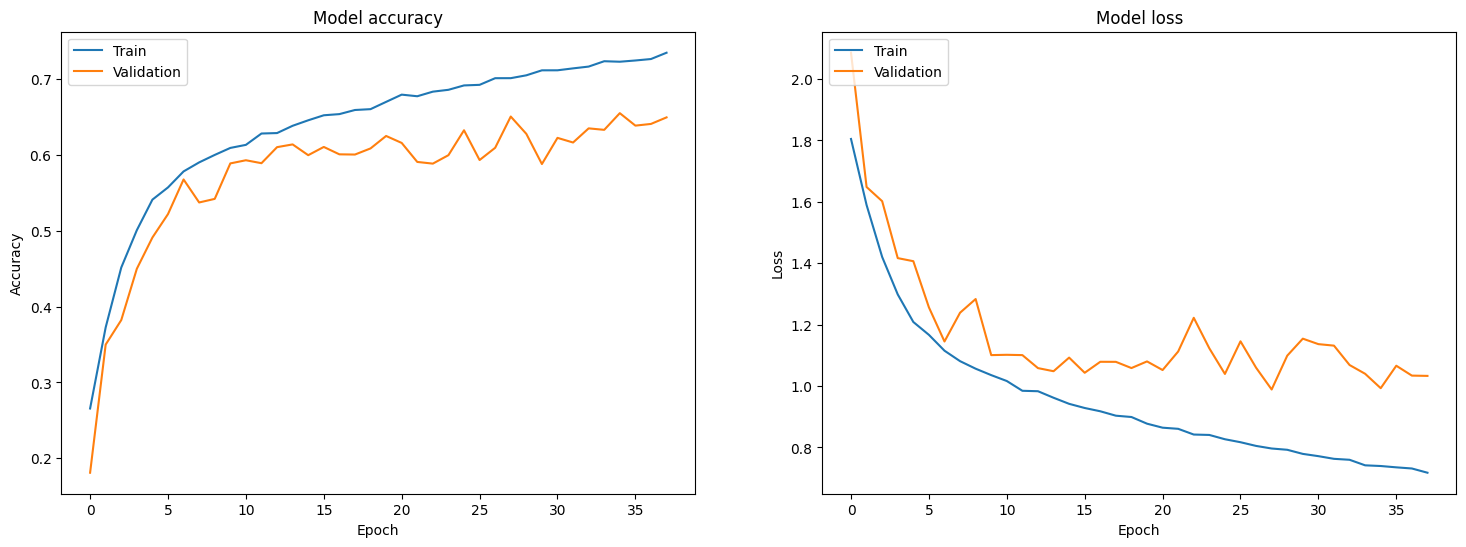

In [31]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Evaluate Test Performance

In [32]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
CNN Model Accuracy on test set: 0.6654


## More Analysis using Confusion Matrix

Confusion Matrix is applied and plotted to find out which emotion usually get confused with each other.

In [33]:
emotion_labels = ['Angry','disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

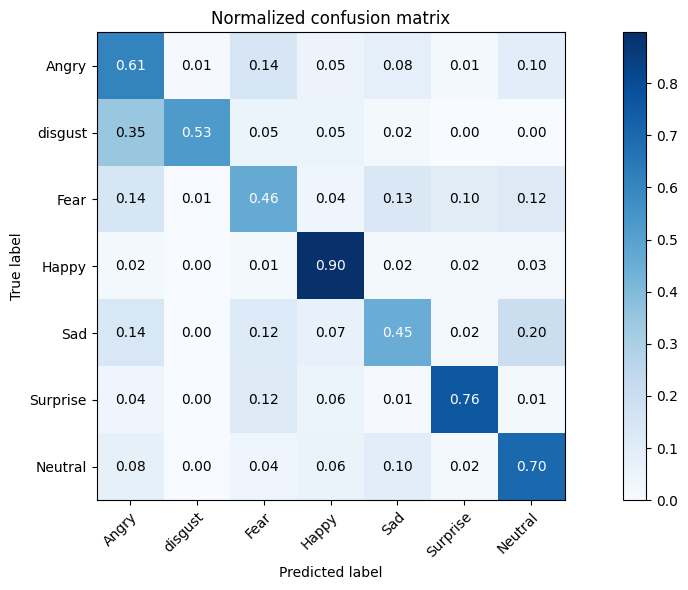

In [34]:
# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

In [35]:
['Angry','disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

['Angry', 'disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [36]:
exp_map = {0 : 'anger', 1:'disgust' , 6 : 'contempt', 2 : 'fear', 3 : 'happy',4 :'sadness',5 :'surprise'}

In [37]:
import math

In [38]:
def anger(p):

    t = 0.343* p + 1.003
    return 2.332 * math.log(t)

def fear(p):

    t = 1.356* p + 1
    return 1.763 * math.log(t)

def contempt(p):
    t = 0.01229* p + 1.036
    return 5.03 * math.log(t)

def disgust(p):
    t = 0.0123* p + 1.019
    return 7.351 * math.log(t)

def happy(p):
    t = 5.221e-5* p + 0.9997
    return 532.2 * math.log(t)

def sad(p):
    t = 0.1328* p + 1.009
    return 2.851 * math.log(t)

def surprise(p):
    t = 0.2825* p + 1.003
    return 2.478 * math.log(t)

In [39]:
samp = test_X[1236]
samp = np.reshape(samp,(1,48,48,1))
samp.shape

(1, 48, 48, 1)

In [40]:
ex_p = model.predict(samp)
ex_p.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step


(1, 7)

In [43]:
correct = []
correcty = []
res = model.predict(X_test)
for i in range(len(y_test)): # Iterate over the length of the CK+ test labels
    if np.argmax(res[i]) == np.argmax(y_test[i]): # Compare with CK+ test labels
        correct.append(res[i])
        correcty.append(y_test[i])
correct = np.array(correct)
correcty = np.array(correcty)
correct.shape

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


(8, 7)

In [44]:
func = [anger,disgust, fear, happy, sad, surprise,contempt]

In [45]:
exp_stress = {}
for i,face in enumerate(correct):
    f = np.argmax(face)
    x = np.max(face)*100

    s = func[f](x)
    sp = s/9*100

    if f not in exp_stress.keys():
        exp_stress[f] = []
        exp_stress[f].append([sp, f, face, correcty[i]])
    else:
        exp_stress[f].append([sp, f, face, correcty[i]])


In [47]:
for emotion_id, data_list in exp_stress.items():
    # emotion_id is np.int64, convert to int for dictionary lookup if necessary
    emotion_name = exp_map.get(int(emotion_id), 'Unknown')
    print(f"Emotion ID {emotion_id} ({emotion_name}):")
    for item in data_list:
        print(item)

Emotion ID 0 (anger):
[79.25596193165299, np.int64(0), array([5.9178436e-01, 3.0240479e-03, 2.2804670e-02, 1.1896137e-05,
       3.6869311e-01, 5.9855625e-04, 1.3083357e-02], dtype=float32), array([1., 0., 0., 0., 0., 0., 0.])]
[88.95621626067118, np.int64(0), array([8.73773813e-01, 1.18337266e-01, 2.79940153e-03, 6.65788639e-06,
       4.96075442e-03, 1.01834039e-05, 1.12020069e-04], dtype=float32), array([1., 0., 0., 0., 0., 0., 0.])]
[67.32140221438037, np.int64(0), array([3.6256811e-01, 1.2797339e-02, 2.7536789e-01, 3.9091290e-05,
       3.0027890e-01, 1.9238923e-02, 2.9709769e-02], dtype=float32), array([1., 0., 0., 0., 0., 0., 0.])]
[81.00341366945779, np.int64(0), array([6.3511109e-01, 5.1343124e-03, 4.4295400e-02, 1.7961969e-04,
       1.7651881e-01, 5.3162238e-04, 1.3822915e-01], dtype=float32), array([1., 0., 0., 0., 0., 0., 0.])]
[82.49947108979039, np.int64(0), array([6.7459852e-01, 3.1345883e-01, 1.3383783e-03, 3.8291968e-04,
       7.1643796e-03, 1.6321383e-04, 2.8935892e